In [50]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

mapbox_access_token = ''
px.set_mapbox_access_token(mapbox_access_token)

In [3]:
import os
os.getcwd()

'c:\\Users\\ucn\\Education\\20202\\DSSGx\\notebooks'

## Read training data for Brazil and Philippines

In [5]:
data_phl = pd.read_csv('../data/training_sets/Philippines/training_set_v001.csv')
data_bra = pd.read_csv('../data/training_sets/Brazil/training_set_v001.csv')

## Get predictors and target

In [14]:
dic = pd.read_excel('../data/meta/training_dict_bra.xlsx', engine='openpyxl')

In [17]:
predictors = dic.loc[dic.role=='predictor', 'name'].values.tolist()
target = dic.loc[dic.role=='target', 'name'].values.tolist()

In [19]:
x_phl = data_phl[predictors]
y_phl = data_phl[target]
x_bra = data_bra[predictors]
y_bra = data_bra[target]

## Initialize and Train the Champion Model on Brazil Data

In [20]:
model = xgb.XGBRegressor(random_state=42, n_estimators=550, max_depth=9, eta=.2, n_jobs=16)
model.fit(x_bra, y_bra)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model Evaluation

In [22]:
exp_phl = dx.Explainer(model, x_phl, y_phl, label = 'xGradient Boosting Philippines')
exp_bra = dx.Explainer(model, x_bra, y_bra, label = 'xGradient Boosting Brazil')

Preparation of a new explainer is initiated

  -> data              : 4599 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 4599 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : xGradient Boosting Philippines
  -> predict function  : <function yhat_default at 0x0000020DA1C13438> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.199, mean = 0.606, max = 1.04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.965, mean = -0.315, max = 0.55
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 11732 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. C

## Permutation Feature Importance for BRA and PHL

In [23]:
mfe_bra = exp_bra.model_parts()
mfe_phl = exp_phl.model_parts()

In [24]:
mfe_bra.plot()
mfe_phl.plot()

## Residual Analysis for BRA and PHL

In [25]:
md_bra = exp_bra.model_diagnostics()
md_phl = exp_phl.model_diagnostics()

In [27]:
md_bra.plot(md_phl)

In [28]:
mp_bra = exp_bra.model_performance(model_type='regression')
mp_phl = exp_phl.model_performance(model_type='regression')

In [31]:
mp_bra.result

mse      rmse        r2       mae       mad
xGradient Boosting Brazil  0.000009  0.002945  0.999788  0.001965  0.001248

In [30]:
mp_phl.result

mse      rmse        r2       mae  \
xGradient Boosting Philippines  0.163321  0.404131 -1.824347  0.352639   

                                     mad  
xGradient Boosting Philippines  0.348828

In [32]:
mp_bra.plot(mp_phl)

In [33]:
tp_bra_phl = len(mp_phl.residuals[(mp_phl.residuals.y_hat<=.3) & (mp_phl.residuals.y<=.3)])
tn_bra_phl = len(mp_phl.residuals[(mp_phl.residuals.y_hat>.3) & (mp_phl.residuals.y>.3)])
fp_bra_phl = len(mp_phl.residuals[(mp_phl.residuals.y_hat<=.3) & (mp_phl.residuals.y>.3)])
fn_bra_phl = len(mp_phl.residuals[(mp_phl.residuals.y_hat>.3) & (mp_phl.residuals.y<=.3)])

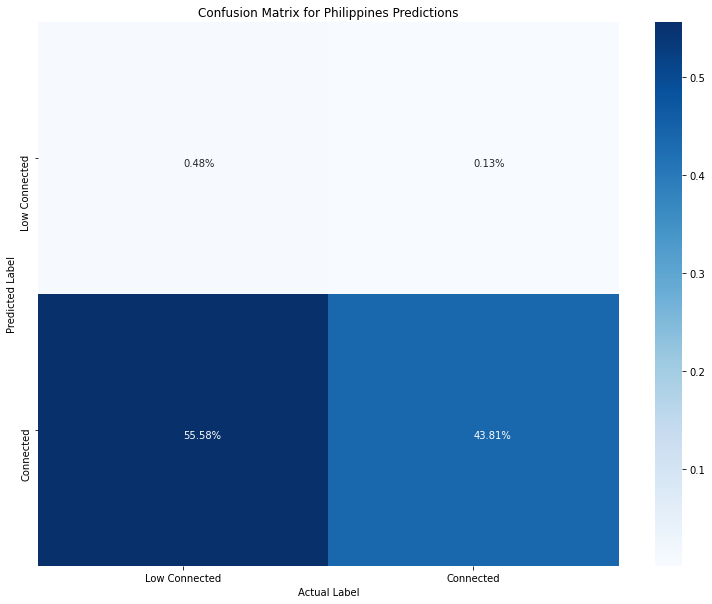

In [48]:
def plot_confusion(tp, tn, fp, fn):  
  conf_arr = np.array([[tp,fp],[fn,tn]])

  sum = conf_arr.sum()

  conf_arr = conf_arr * 100.0 / ( 1.0 * sum )

  df_cm = pd.DataFrame(conf_arr, 
    index = [ 'Low Connected', 'Connected'],
    columns = ['Low Connected', 'Connected'])

  fig ,ax = plt.subplots(figsize=(13,10))
  conf_plt = sns.heatmap(df_cm/100, annot=True, fmt='.2%', cmap='Blues', annot_kws={"ha": 'left',"va": 'top'});
  ax.set_ylim([0,2]);
  conf_plt.invert_yaxis()
  ax.title.set_text('Confusion Matrix for Philippines Predictions')
  ax.set_ylabel('Predicted Label');
  ax.set_xlabel('Actual Label');

plot_confusion(tp_bra_phl, tn_bra_phl, fp_bra_phl, fn_bra_phl)

## Training a new model on Philippines data with Brazil hyperparameters

In [40]:
model_phl = xgb.XGBRegressor(random_state=42, n_estimators=550, max_depth=9, eta=.2, n_jobs=16)
model_phl.fit(x_phl, y_phl)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Model Evaluation

In [41]:
exp = dx.Explainer(model_phl, x_phl, y_phl, label='xGradient Boosting Philippines trained')

Preparation of a new explainer is initiated

  -> data              : 4599 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 4599 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : xGradient Boosting Philippines
  -> predict function  : <function yhat_default at 0x0000020DA1C13438> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -0.00375, mean = 0.291, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.00818, mean = -1.84e-08, max = 0.00895
  -> model_info        : package xgboost

A new explainer has been created!


## Permutation Feature Importance for Philippines

In [43]:
mfe_exp = exp.model_parts()

In [44]:
mfe_exp.plot()
mfe_bra.plot()

## Residual Analysis

In [46]:
md_exp = exp.model_diagnostics()
md_exp.plot(md_bra)

In [67]:
mp_exp = exp.model_performance(model_type='regression')
mp_exp.plot(mp_bra)

## Model Performance

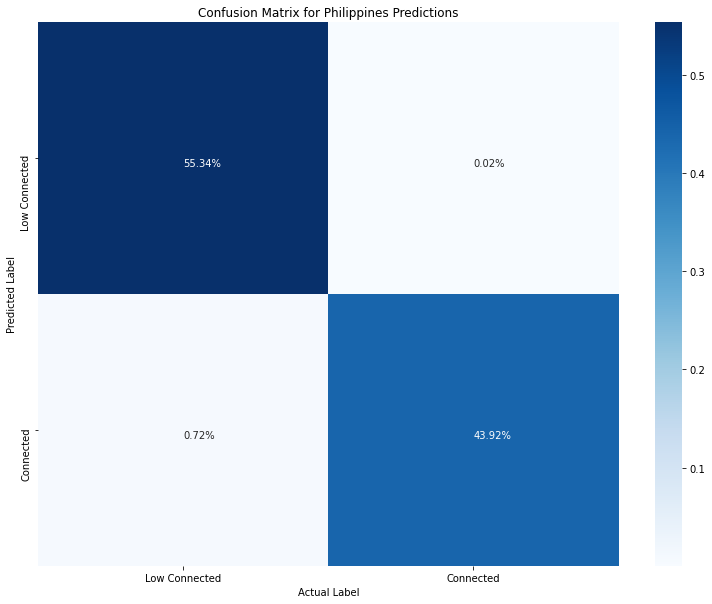

In [49]:
tp = len(mp_exp.residuals[(mp_exp.residuals.y_hat<=.3) & (mp_exp.residuals.y<=.3)])
tn = len(mp_exp.residuals[(mp_exp.residuals.y_hat>.3) & (mp_exp.residuals.y>.3)])
fp = len(mp_exp.residuals[(mp_exp.residuals.y_hat<=.3) & (mp_exp.residuals.y>.3)])
fn = len(mp_exp.residuals[(mp_exp.residuals.y_hat>.3) & (mp_exp.residuals.y<=.3)])
plot_confusion(tp, tn, fp, fn)

## Geo-Visuals

In [65]:
def plot_map(lat_arr, lon_arr, color_arr):
    fig = go.Figure(go.Scattermapbox(
            lat=lat_arr,
            lon=lon_arr,
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=3, color= color_arr,
                showscale=True,
                colorscale=px.colors.diverging.RdYlGn,
            ),
            text=['Montreal'],
        ))

    fig.update_layout(
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            style='dark',
            center = {"lat": lat_arr.mean(), "lon": lon_arr.mean()},
            bearing=0,
            pitch=0,
            zoom=4,
        )
    )

    fig.show()

In [66]:
plot_map(data_phl.latitude, data_phl.longitude, mp_phl.residuals.y_hat)
plot_map(data_phl.latitude, data_phl.longitude, mp_exp.residuals.y_hat)
plot_map(data_phl.latitude, data_phl.longitude, mp_exp.residuals.y)

In [81]:
(mp_phl.residuals.y_hat).mean()

0.6059076

In [82]:
(mp_phl.residuals.y).mean()

0.29134710844377765